In [3]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

import matplotlib.pyplot as plt
%matplotlib inline

Setting environment for Gordon


In [4]:
from skimage.transform import rotate

In [160]:
cell_masks = []

In [161]:
stack = 'MD589'

for sec in range(93, 143, 10):
# sec = 113
    blob_coords = pickle.load(open('/home/yuncong/csd395/CSHL_cells/%(stack)s_%(sec)04d_blobCoords.pkl' % {'stack': stack, 'sec': sec}, 'r'))
    blob_orientations = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_cells/%(stack)s_%(sec)04d_blobOrientations.bp' % {'stack': stack, 'sec': sec})

    blob_centers = [coords.mean(axis=0) for coords in blob_coords]

    for blob_index_inSec, coords in enumerate(blob_coords):
        ymin, xmin = coords.min(axis=0)
        ymax, xmax = coords.max(axis=0)
        cell_mask = np.zeros((ymax+1-ymin, xmax+1-xmin), np.bool)
        cell_mask[coords[:,0]-ymin, coords[:,1]-xmin] = 1

        patch_rotationNormalized = rotate(cell_mask, angle=-np.rad2deg(blob_orientations[blob_index_inSec]), 
                      center=(blob_centers[blob_index_inSec][1] - xmin, blob_centers[blob_index_inSec][0] - ymin),
                      cval=0.) > .5

        cell_masks.append(patch_rotationNormalized)

In [162]:
cell_masks_normalized = pad_patches_to_same_size(cell_masks, pad_value=0, keep_center=True)

In [163]:
n_cells = len(cell_masks_normalized)
print n_cells, 'cells'

cell_masks_normalized_flattened = np.reshape(cell_masks_normalized, (len(cell_masks_normalized), -1))
cell_masks_normalized_flattened.shape

cell_masks_normalized_size = cell_masks_normalized_flattened.sum(axis=1)

197953 cells


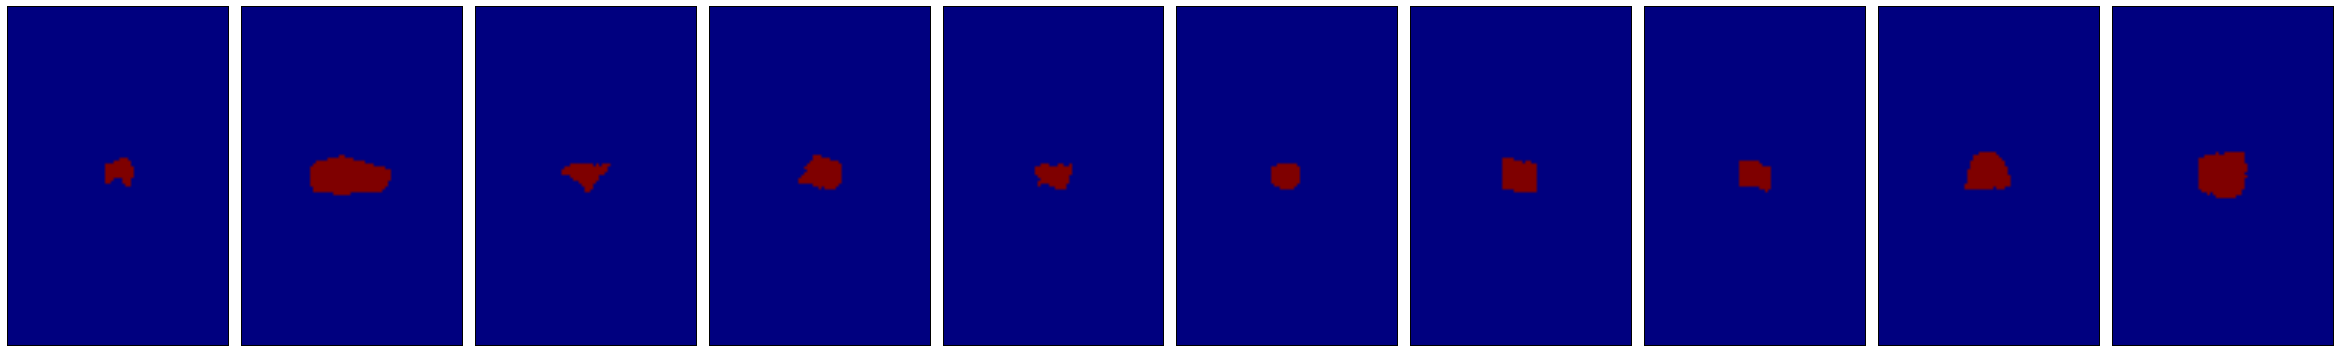

In [164]:
# visualize some random cells
indices = np.random.randint(0, n_cells, 10)
display_images_in_grids([cell_masks_normalized[i] for i in indices], 10, maintain_shape=False)

In [165]:
def compute_jaccard_with_i_slave(args):
    i, j1, j2 = args
    intersections_with_i = (cell_masks_normalized_flattened[i] & cell_masks_normalized_flattened[j1:j2+1]).sum(axis=1)
    unions_with_i = (cell_masks_normalized_size[i] + cell_masks_normalized_size[j1:j2+1] - intersections_with_i)
    return 1 - intersections_with_i.astype(np.float)/unions_with_i

def compute_jaccard_with_i_parallel(i):
    
    from multiprocess import Pool
    
    pool = Pool(16)

    slave_start_indices = np.linspace(0, n_cells, 17).astype(np.int)
    jaccard_with_i = pool.map(compute_jaccard_with_i_slave,
                              [(i, slave_start_indices[s], slave_start_indices[s+1]-1) for s in range(16)])
    jaccard_with_i = np.concatenate(jaccard_with_i)

    pool.terminate()
    pool.close()
            
    return jaccard_with_i

In [166]:
def compute_jaccard_with_i(i, upper=False):
    if upper:
        intersections_with_i = (cell_masks_normalized_flattened[i] & cell_masks_normalized_flattened[i+1:]).sum(axis=1)
        unions_with_i = (cell_masks_normalized_size[i] + cell_masks_normalized_size[i+1:] - intersections_with_i)
    else:
        intersections_with_i = (cell_masks_normalized_flattened[i] & cell_masks_normalized_flattened).sum(axis=1)
        unions_with_i = (cell_masks_normalized_size[i] + cell_masks_normalized_size - intersections_with_i)
    return 1 - intersections_with_i.astype(np.float)/unions_with_i

In [167]:
def compute_jaccard_with_template(template):
    intersections_with_template = [template[m].sum() for m in cell_masks_normalized_flattened]
    unions_with_template = (template + cell_masks_normalized_size - intersections_with_template)
    return 1 - intersections_with_template.astype(np.float)/unions_with_template

In [ ]:
# Use K-means++ to select 100 seeds, then assign clusters and compute radius

In [180]:
n_class = 1000

In [ ]:
distances_to_seeds = np.empty((n_class, n_cells))
cluster_radius_evolution = np.empty((n_class, ))
seeds = np.empty((n_class, ))

t1 = time.time()

for it in range(n_class):
        
    if it == 0:
        seed = np.random.randint(n_cells)
    else:
        seed = np.random.choice(range(n_cells), 1, p=d2_weights)[0]
        
    seeds[it] = seed
    
#     t = time.time()
    distances = compute_jaccard_with_i(seed)
#     distances = compute_jaccard_with_i_parallel(seed)
#     print time.time() - t
# 0.4s / 4k cells ； 9s / 20k cells

    distances_to_seeds[it] = distances
    d = np.atleast_2d(distances_to_seeds[:it+1])
    
#     t = time.time()
    distances_to_closest_seed = d.min(axis=0)
#     print time.time() - t

#     t = time.time()
#     index_of_closest_seed = d.argmin(axis=0)
#     print time.time() - t
    
    d2s = distances_to_closest_seed**2
    d2_weights = d2s / d2s.sum()
    
    cluster_radius = np.max(distances_to_closest_seed)
    cluster_radius_evolution[it] = cluster_radius
    
print time.time() - t1

In [174]:
index_of_closest_seed = d.argmin(axis=0)

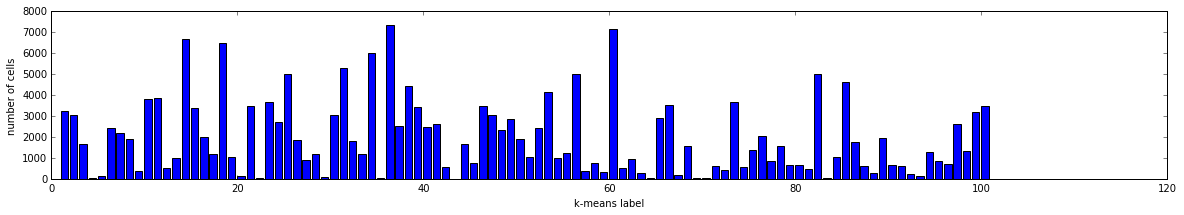

In [175]:
plt.figure(figsize=(20,3));
plt.bar(1+np.arange(n_class), np.bincount(index_of_closest_seed, minlength=n_class));
plt.xlabel('k-means label');
plt.ylabel('number of cells');

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


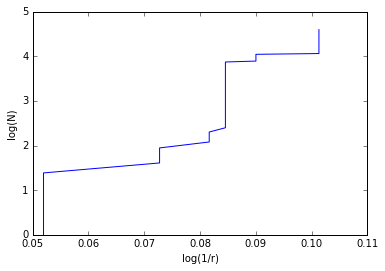

In [176]:
plt.plot(np.log(1./cluster_radius_evolution), np.log(np.arange(n_class)));
plt.xlabel('log(1/r)');
plt.ylabel('log(N)');

In [177]:
fractal_dimensions = np.log(np.arange(n_class))/np.log(1./cluster_radius_evolution)

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


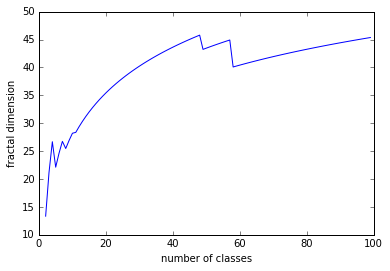

In [178]:
valid_starting_from = np.where(~np.isnan(fractal_dimensions) & ~np.isinf(fractal_dimensions) & (fractal_dimensions > 0))[0].min()
plt.plot(np.arange(valid_starting_from, n_class), fractal_dimensions[valid_starting_from:]);
plt.xlabel('number of classes');
plt.ylabel('fractal dimension');

In [179]:
valid_fractal_dimensions = fractal_dimensions[valid_starting_from:]
print 'Estimated fractal dimension :', 'lower bound =', np.min(valid_fractal_dimensions), \
        ', upper bound =', np.max(valid_fractal_dimensions)

Estimated fractal dimension : lower bound = 13.3400820486 , upper bound = 45.781936992
